# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [5]:
import pandas as pd
import plotly.express as px

In [6]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [7]:
# Check for missing values
missing_values = df.isna().mean().round(4) * 100
missing_values

age               0.0
job               0.0
marital           0.0
education         0.0
default           0.0
housing           0.0
loan              0.0
contact           0.0
month             0.0
day_of_week       0.0
duration          0.0
campaign          0.0
pdays             0.0
previous          0.0
poutcome          0.0
emp.var.rate      0.0
cons.price.idx    0.0
cons.conf.idx     0.0
euribor3m         0.0
nr.employed       0.0
y                 0.0
dtype: float64

In [8]:
# Check for duplicates
duplicates = df[df.duplicated()]
print(f"Number of duplicate rows: {duplicates.shape[0]}")

Number of duplicate rows: 12


In [9]:
# Check details of duplicates including original
df['duplicate_count'] = df.groupby(list(df.columns))[list(df.columns)[0]].transform('count')
duplicates_all = df[df.duplicated(keep=False)].sort_values(by=list(df.columns), kind='mergesort')

print(f"Number of duplicated records (including originals): {duplicates_all.shape[0]}")
duplicates_all

Number of duplicated records (including originals): 24


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,duplicate_count
28476,24,services,single,high.school,no,yes,no,cellular,apr,tue,...,999,0,nonexistent,-1.8,93.075,-47.1,1.423,5099.1,no,2
28477,24,services,single,high.school,no,yes,no,cellular,apr,tue,...,999,0,nonexistent,-1.8,93.075,-47.1,1.423,5099.1,no,2
14155,27,technician,single,professional.course,no,no,no,cellular,jul,mon,...,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no,2
14234,27,technician,single,professional.course,no,no,no,cellular,jul,mon,...,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no,2
18464,32,technician,single,professional.course,no,yes,no,cellular,jul,thu,...,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,no,2
18465,32,technician,single,professional.course,no,yes,no,cellular,jul,thu,...,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,no,2
32505,35,admin.,married,university.degree,no,yes,no,cellular,may,fri,...,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no,2
32516,35,admin.,married,university.degree,no,yes,no,cellular,may,fri,...,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no,2
12260,36,retired,married,unknown,no,no,no,telephone,jul,thu,...,999,0,nonexistent,1.4,93.918,-42.7,4.966,5228.1,no,2
12261,36,retired,married,unknown,no,no,no,telephone,jul,thu,...,999,0,nonexistent,1.4,93.918,-42.7,4.966,5228.1,no,2


In [10]:
# Remove duplicates, keep first occurrence
df_nodups = df.drop_duplicates()
print(f"Rows before: {df.shape[0]}, after: {df_nodups.shape[0]}")


Rows before: 41188, after: 41176


In [11]:
# Delete duplicate count column since it is no longer needed
df_nodups.drop(columns=['duplicate_count'], inplace=True)
df_nodups

/var/folders/bs/1wybxlr17fg3bj7w8dhxkg1r0000gn/T/ipykernel_3399/3840494970.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nodups.drop(columns=['duplicate_count'], inplace=True)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [12]:
 # Look at number of rows/columns, summary statistics and data types (total counts of numberical/categorical)
print("The data has {} rows and {} columns".format(df_nodups.shape[0], df_nodups.shape[1]))
display(df_nodups.describe())
display(df_nodups.dtypes.value_counts())

The data has 41176 rows and 21 columns


,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41176.00000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000
mean,40.02380,258.315815,2.567879,962.464810,0.173013,0.081922,93.575720,-40.502863,3.621293,5167.034870
std,10.42068,259.305321,2.770318,186.937102,0.494964,1.570883,0.578839,4.627860,1.734437,72.251364
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


object     11
int64       5
float64     5
dtype: int64

### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [14]:
df_nodups.drop(['contact', 'month', 'day_of_week', 'campaign', 'pdays', 'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx','cons.conf.idx', 'euribor3m', 'nr.employed'], axis=1, inplace=True)
df_nodups

/var/folders/bs/1wybxlr17fg3bj7w8dhxkg1r0000gn/T/ipykernel_3399/2445258745.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nodups.drop(['contact', 'month', 'day_of_week', 'campaign', 'pdays', 'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx','cons.conf.idx', 'euribor3m', 'nr.employed'], axis=1, inplace=True)


,age,job,marital,education,default,housing,loan,duration,y
0,56,housemaid,married,basic.4y,no,no,no,261,no
1,57,services,married,high.school,unknown,no,no,149,no
2,37,services,married,high.school,no,yes,no,226,no
3,40,admin.,married,basic.6y,no,no,no,151,no
4,56,services,married,high.school,no,no,yes,307,no
...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,334,yes
41184,46,blue-collar,married,professional.course,no,no,no,383,no
41185,56,retired,married,university.degree,no,yes,no,189,no
41186,44,technician,married,professional.course,no,no,no,442,yes


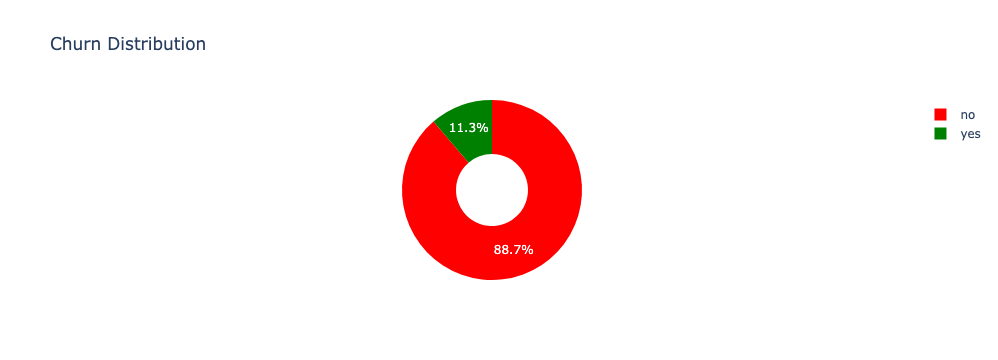

In [33]:
# Visualize churn distribution and observe if there is an imbalance

fig = px.pie(
    df_nodups,
    names='y',
    title='Churn Distribution',
    hole=0.4,
    color_discrete_sequence=['#FF0000', '#008000'] 
)
fig.update_traces(textposition='inside', textinfo='percent')
fig.show()

In [37]:
# Examine columns job, marital and education - list unique values

unique_values = {col: df[col].unique() for col in ['job', 'marital', 'education']}
print(unique_values)

{'job': array(['housemaid', 'services', 'admin.', 'blue-collar', 'technician',
       'retired', 'management', 'unemployed', 'self-employed', 'unknown',
       'entrepreneur', 'student'], dtype=object), 'marital': array(['married', 'single', 'divorced', 'unknown'], dtype=object), 'education': array(['basic.4y', 'high.school', 'basic.6y', 'basic.9y',
       'professional.course', 'unknown', 'university.degree',
       'illiterate'], dtype=object)}


In [39]:
df_nodups['y'] = df_nodups['y'].map({'no':0, 'yes':1})
df_nodups

/var/folders/bs/1wybxlr17fg3bj7w8dhxkg1r0000gn/T/ipykernel_3399/3337220532.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,age,job,marital,education,default,housing,loan,duration,y
0,56,housemaid,married,basic.4y,no,no,no,261,0
1,57,services,married,high.school,unknown,no,no,149,0
2,37,services,married,high.school,no,yes,no,226,0
3,40,admin.,married,basic.6y,no,no,no,151,0
4,56,services,married,high.school,no,no,yes,307,0
...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,334,1
41184,46,blue-collar,married,professional.course,no,no,no,383,0
41185,56,retired,married,university.degree,no,yes,no,189,0
41186,44,technician,married,professional.course,no,no,no,442,1


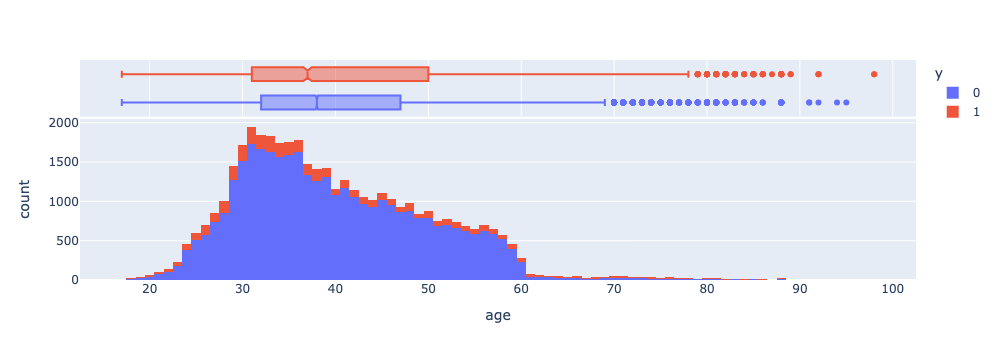

In [48]:
# Exaime age distribution and subscription status

fig = px.histogram(df_nodups, x="age", color='y', marginal='box')
fig.show()

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 1 columns):
 #   Column                                                                                                                                                                                                                        Non-Null Count  Dtype 
---  ------                                                                                                                                                                                                                        --------------  ----- 
 0   age;"job";"marital";"education";"default";"housing";"loan";"contact";"month";"day_of_week";"duration";"campaign";"pdays";"previous";"poutcome";"emp.var.rate";"cons.price.idx";"cons.conf.idx";"euribor3m";"nr.employed";"y"  4119 non-null   object
dtypes: object(1)
memory usage: 32.3+ KB


### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

### Problem 9: Score the Model

What is the accuracy of your model?

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

##### Questions